<a href="https://colab.research.google.com/github/mlangsman/fastai-experiments/blob/main/Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🤖 Classifier Experiment

## 📁 Install dependencies

We need the Fastai library for model training and DuckDuckGo search to retrieve images for our dataset.


In [1]:
!pip install -Uqq fastai ddgs

## Download images

Create a function which can download images using the DuckDuckGo API for training.

In [2]:
from ddgs import DDGS
from fastcore.all import *

def search_images(keywords, max_images=20):
  results = DDGS().images(keywords, max_results=max_images) #run a search
  imageUrls = L(results).itemgot('image') #extract just image urls
  return imageUrls


Classifying UPF food is a little trickier than say cats/dogs. Here I create a list of search terms for specific foods and so we can then grab images for each


In [3]:
# Ultra-processed food terms (UPF)
upf_terms = [
    "Big Mac burger",
    "Doritos crisps",
    "KitKat bar",
    "Oreo cookies",
    "Pringles tube",
    "Pot Noodle",
    "Twix bar",
    "Haribo sweets",
    "Coca-Cola can",
    "Fanta bottle",
    "Red Bull can",
    "Pop-Tarts",
    "Ben & Jerry's ice cream tub",
    "Chicken nuggets",
    "Pepperami",
    "Frozen pizza",
    "Pot noodle",
    "Mars bar",
    "Snickers bar",
    "Chocolate bar"
    "Walkers crisps",
    "Crisps"
]

# Fresh / minimally-processed foods
fresh_terms = [
    "Apple fruit",
    "Banana fruit",
    "Broccoli",
    "Carrot",
    "Tomato",
    "Cucumber",
    "Lettuce",
    "Blueberries",
    "Strawberries",
    "Eggs",
    "Whole chicken raw",
    "Salmon fillet",
    "Beef steak",
    "Brown rice bowl",
    "Oats porridge",
    "Almonds nuts",
    "Avocado",
    "Red bell pepper",
    "Courgette",
    "Mushrooms"
]

Let's create a function to downloading some images for each term. FastAi's download_url() seems to stall on some urls so here I'm doing an http request instead to get the images.

In [16]:
from fastdownload import download_url
from fastai.vision.all import *
from io import BytesIO
import random

thumbs = []

def download_image_sets(search_term_list, dest_path, max_images):
  for item in search_term_list:
    urls = search_images(item, max_images=max_images)
    for i, url in enumerate(urls):
      file_name = f"{item.replace(' ', '_')}_{i}.jpg"
      dest = dest_path/file_name
      try:
        r = requests.get(url, timeout=4, headers={"User-Agent": "Mozilla/5.0"})
        r.raise_for_status()
        if "image" not in r.headers.get("Content-Type", ""): # skip non-image content
          continue

        # Create image from raw bytes and also write to disk
        img = PILImage.create(BytesIO(r.content))
        with open(dest, "wb") as f:
                  f.write(r.content)
        thumbs.append(img.to_thumb(64,64))
      except Exception as e:
        continue

  #show_images(thumbs, nrows=len(upf_terms))

Test this out with a small no. images to check if the results make sense



In [ ]:
download_image_sets(upf_terms,3)

This looks good so lets download 10 images for each search term and save them in folders for the two categories

In [ ]:
from time import sleep

searches = {
    "upf": upf_terms,
    "fresh": fresh_terms
}

path = Path('upf_or_not')

for label, terms in searches.items():
    dest = (path/label)
    dest.mkdir(exist_ok=True, parents=True)
    download_image_sets(terms,dest,10)
    sleep(10)  # Pause between searches to avoid over-loading server
    resize_images(path/label, max_size=400, dest=path/label)

## 🏋 Train the model

Remove any images which didnt download properly and may affect training


In [19]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

To train the model first we create a DataBlock which defines:

* We're inputting image data, and mapping to categories
* get_image_files to get the input items
* We randomly split the images 80/20 for training/validation and the seed lets us recreate this split again.
* Label with be the folder name
* We'll tranform the item to all be 192x192


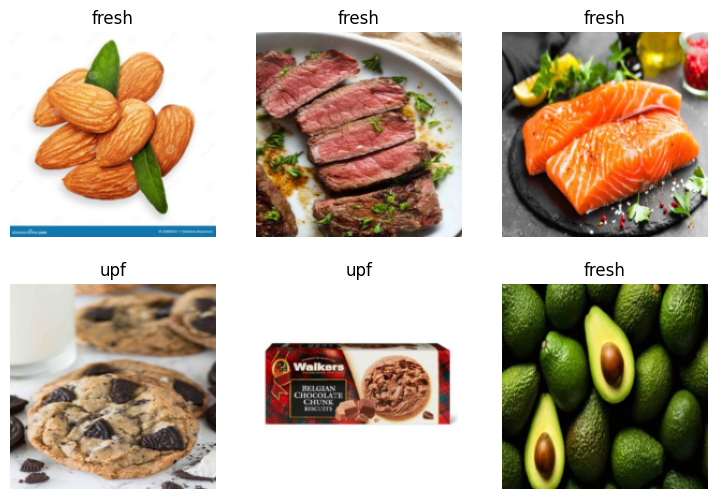

In [20]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)